In [1]:
import glob
import pickle
from scipy.misc import imread
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
import time

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Read the Data

In [ ]:
GTI_noncar_images = glob.glob('training_data/non-vehicles/GTI/*.png')
extras_noncar_images = glob.glob('training_data/non-vehicles/Extras/*.png')

GTI_car_images_far = glob.glob('training_data/vehicles/GTI_Far/*.png')
GTI_car_images_left = glob.glob('training_data/vehicles/GTI_Left/*.png')
GTI_car_images_close = glob.glob('training_data/vehicles/GTI_MiddleClose/*.png')
GTI_car_images_right = glob.glob('training_data/vehicles/GTI_Right/*.png')
KITTI_car_images = glob.glob('training_data/vehicles/KITTI_extracted/*.png')

GTI_noncar = [image for image in GTI_noncar_images]
extras_noncar = [image for image in extras_noncar_images]
notcar_list = GTI_noncar + extras_noncar

cars_far = [image for image in GTI_car_images_far]
cars_left = [image for image in GTI_car_images_left]
cars_close = [image for image in GTI_car_images_close]
cars_right = [image for image in GTI_car_images_right]
cars_KITTI = [image for image in KITTI_car_images]
car_list = cars_far + cars_left + cars_close + cars_right + cars_KITTI
       
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(car_list, notcar_list)
print(data_info)

## Feature Extraction Functions

In [11]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def single_img_features(img, color_space='RGB', 
                        spatial_feat=True, spatial_size=(32, 32),
                        hist_feat=True, hist_bins=32, 
                        hog_feat=True, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                          ):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

## Set the Parameters

In [2]:
color_space = 'HLS' # Decided to use HLS channel

spatial_feat = True # Spatial features on or off
spatial_size = (32, 32) # Spatial binning dimensions

hist_feat = True # Histogram features on or off
hist_bins = 32    # Number of histogram bins

hog_feat = True # HOG features on or off
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"

## Extract Features

In [ ]:
car_features = []
notcar_features = []

for file in car_list:
    img = imread(file)
    car_features.append(single_img_features(img,color_space, 
                                           spatial_feat, spatial_size,
                                           hist_feat, hist_bins, 
                                           hog_feat, orient, pix_per_cell, cell_per_block, hog_channel)) 

for file in notcar_list:
    img = imread(file)
    notcar_features.append(single_img_features(img,color_space, 
                                           spatial_feat, spatial_size,
                                           hist_feat, hist_bins, 
                                           hog_feat, orient, pix_per_cell, cell_per_block, hog_channel))

## Use Linear SVC to train

In [ ]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()
# enable probability output
clf = CalibratedClassifierCV(svc) 

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train SVC...')

#save the scaler to a file
with open('X_scaler.pkl', 'wb') as f:
    pickle.dump(X_scaler, f)

#save the classifier to a file
with open('linearSVC_clf.pkl', 'wb') as f:
    pickle.dump(clf, f)
    
# Check the score of the SVC
print('Train Accuracy of SVC = ', clf.score(X_train, y_train))
print('Test Accuracy of SVC = ', clf.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
prediction = clf.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVC')

## test on images

In [104]:
#loead the classifier
with open('linearSVC_clf.pkl', 'rb') as f:
    clf = pickle.load(f)
    
#load the scaler
with open('X_scaler.pkl', 'rb') as f:
    X_scaler = pickle.load(f)
    
#read test images
#img1 = imread('test_images/test1.jpg')
#img2 = imread('test_images/test2.jpg')
#img3 = imread('test_images/test3.jpg')
#img4 = imread('test_images/test4.jpg')
#img5 = imread('test_images/test5.jpg')
#img6 = imread('test_images/test6.jpg')

img1 = imread('video images/project_video-001.jpg')
img2 = imread('video images/project_video-003.jpg')
img3 = imread('video images/project_video-005.jpg')
img4 = imread('video images/project_video-007.jpg')
img5 = imread('video images/project_video-009.jpg')
img6 = imread('video images/project_video-011.jpg')

## Slide Windows

In [4]:
## helper functions
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

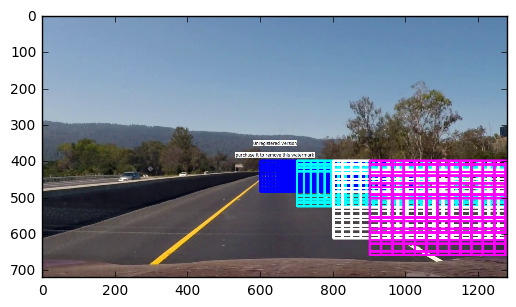

In [100]:
#plot the windows
small_windows = []
mid_windows = []
big_windows = []
huge_windows = []
draw_img = np.copy(img1)

for i in range(2):
    small_windows += slide_window(img1, x_start_stop=[600, 1000], y_start_stop=[400+i*10, 448+i*10], 
                    xy_window=(48, 48), xy_overlap=(0.8, 0.8))

for i in range(2):
    mid_windows += slide_window(img1, x_start_stop=[700, None], y_start_stop=[400+i*10, 464+i*10], 
                    xy_window=(96, 96), xy_overlap=(0.8, 0.8))    

for i in range(2):
    big_windows += slide_window(img1, x_start_stop=[800, None], y_start_stop=[400+i*10, 528+i*10], 
                    xy_window=(128, 128), xy_overlap=(0.8, 0.8))        
    
for i in range(2):
    huge_windows += slide_window(img1, x_start_stop=[900, None], y_start_stop=[400+i*10, 556+i*10], 
                    xy_window=(156, 156), xy_overlap=(0.8, 0.8))        
    
    
windows_img = draw_boxes(draw_img, small_windows, color=(0, 0, 255), thick=6)      
windows_img = draw_boxes(windows_img, mid_windows, color=(0, 255, 255), thick=6)      
windows_img = draw_boxes(windows_img, big_windows, color=(255, 255, 255), thick=6)     
windows_img = draw_boxes(windows_img, huge_windows, color=(255, 0, 255), thick=6)     

windows = small_windows + mid_windows + big_windows + huge_windows

plt.imshow(windows_img)

## Search Windows

In [111]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
#        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
#        #6) Predict using your classifier
        prob = clf.predict_proba(test_features)
#        #7) If confidence level higher than 0.9 then save the window
        if prob[0][1] > 0.65:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def detect_hot_windows(test_img):
    draw_image = np.copy(test_img)
    hot_windows = search_windows(test_img, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
    return hot_windows, window_img

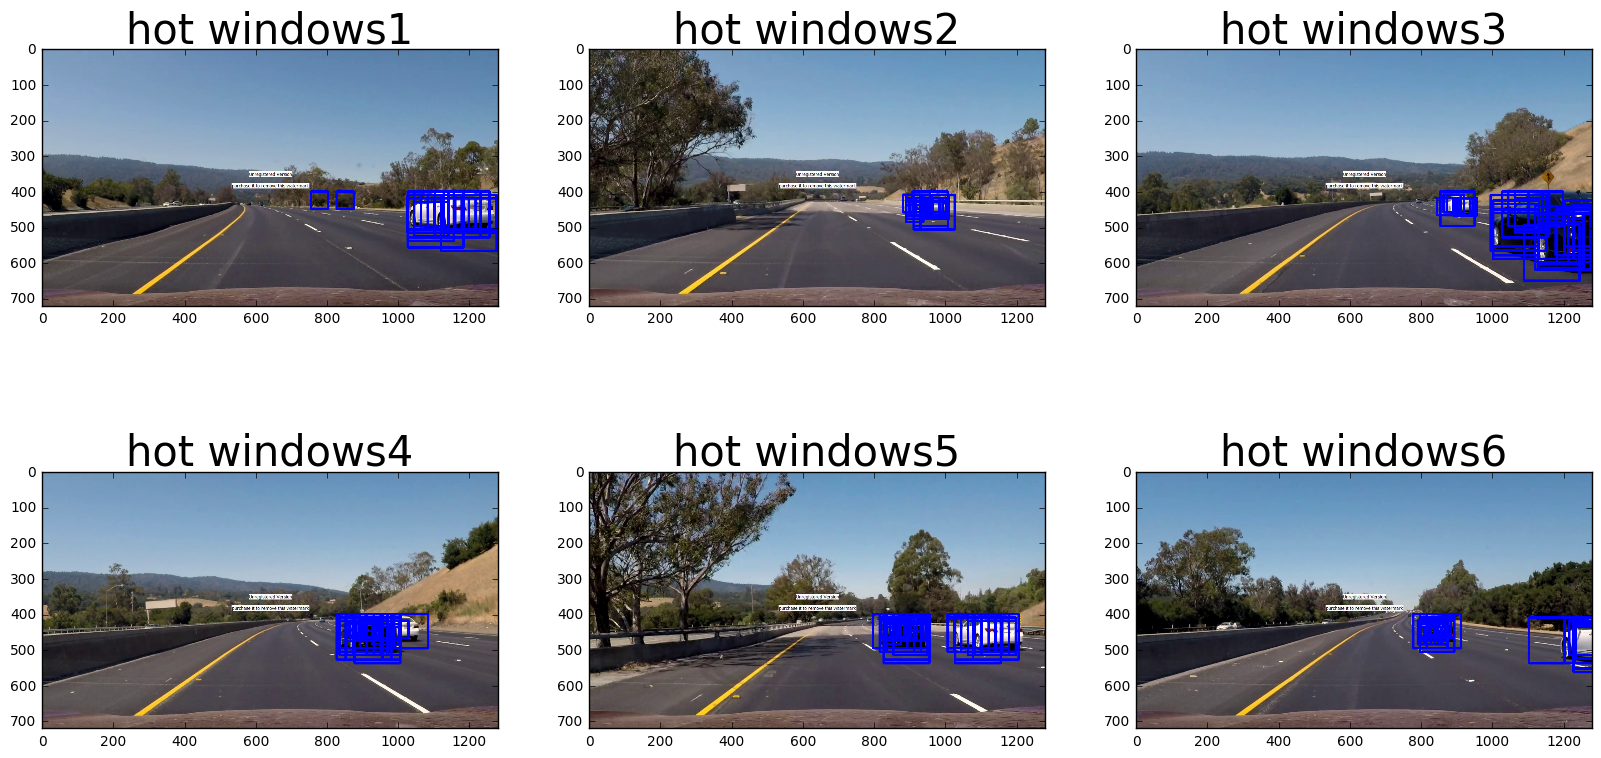

In [109]:
# test hot windows on images
hot_windows1,res1 = detect_hot_windows(img1)
hot_windows2,res2 = detect_hot_windows(img2)
hot_windows3,res3 = detect_hot_windows(img3)
hot_windows4,res4 = detect_hot_windows(img4)
hot_windows5,res5 = detect_hot_windows(img5)
hot_windows6,res6 = detect_hot_windows(img6)

f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))
ax1.imshow(res1)
ax1.set_title('hot windows1', fontsize=30)
ax2.imshow(res2)
ax2.set_title('hot windows2', fontsize=30)
ax3.imshow(res3)
ax3.set_title('hot windows3', fontsize=30)
ax4.imshow(res4)
ax4.set_title('hot windows4', fontsize=30)
ax5.imshow(res5)
ax5.set_title('hot windows5', fontsize=30)
ax6.imshow(res6)
ax6.set_title('hot windows6', fontsize=30)

## vehicle detection

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 20

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = (((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))) 
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [19]:
def detect_vehicle(frame):
    draw_image = np.copy(frame)
    #search windows
    hot_windows = search_windows(frame, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    #heatmap
    heatmap = np.zeros_like(img1[:,:,0])
    heatmap = add_heat(heatmap,hot_windows)
    heatmap = apply_threshold(heatmap,40)
    #label the heatmap
    s = [[1,1,1],
         [1,1,1],
         [1,1,1]]
    labels = label(heatmap,structure=s)
    #draw the labels
    car_labeled = draw_labeled_bboxes(draw_image,labels)  
    
    return car_labeled

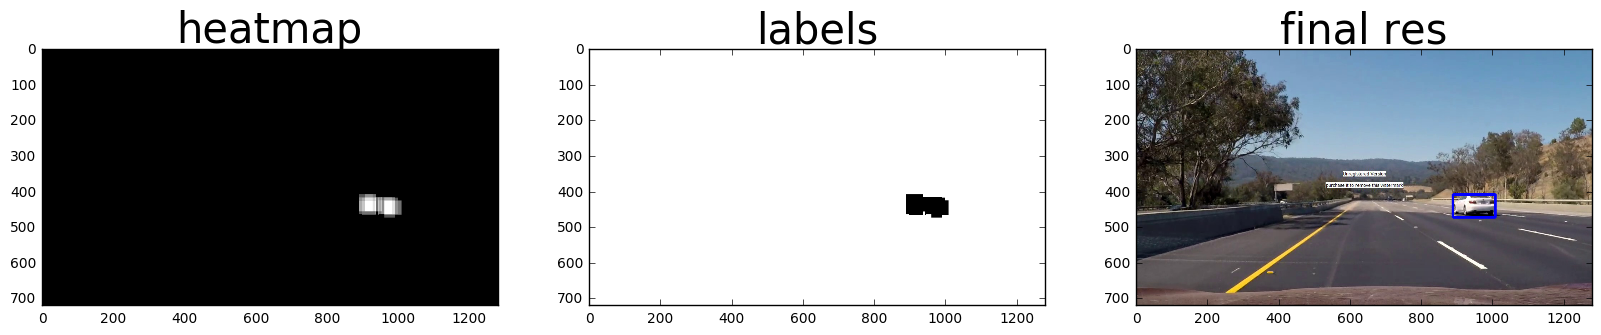

In [56]:
## single image test
heatmap = np.zeros_like(img2[:,:,0])
heatmap = add_heat(heatmap,hot_windows2)
heatmap = apply_threshold(heatmap,40)

## label the heatmap
# treat diagonal pixels as connected
s = [[1,1,1],
     [1,1,1],
     [1,1,1]]
labels = label(heatmap,structure=s)

## draw the labels
draw_image = np.copy(img2)
car_labeled = draw_labeled_bboxes(draw_image,labels)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(heatmap,cmap='gray')
ax1.set_title('heatmap', fontsize=30)
ax2.imshow(labels[0],cmap='binary')
ax2.set_title('labels', fontsize=30)
ax3.imshow(car_labeled)
ax3.set_title('final res', fontsize=30)

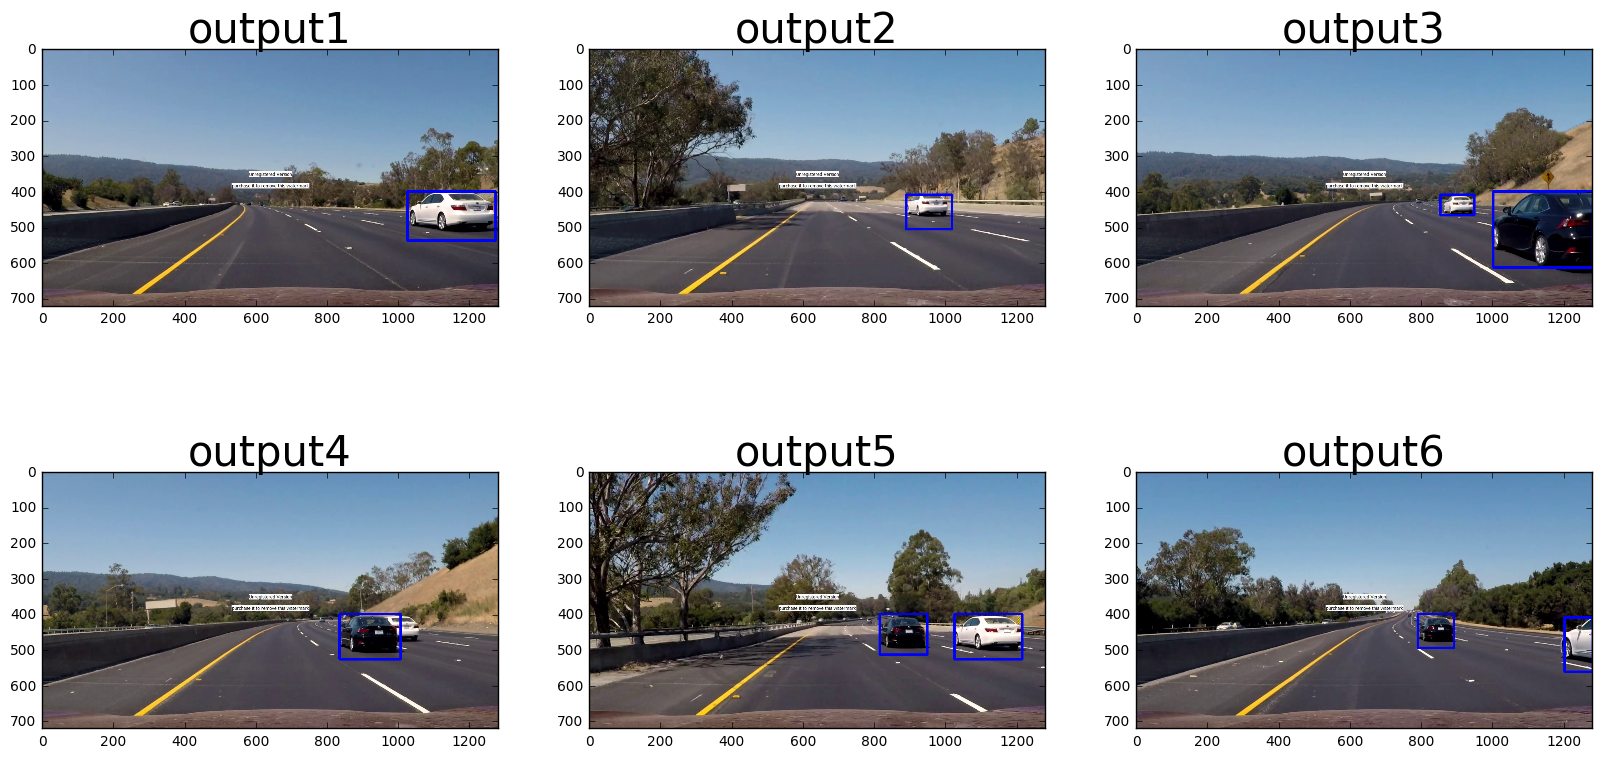

In [112]:
# test on images
res1 = detect_vehicle(img1)
res2 = detect_vehicle(img2)
res3 = detect_vehicle(img3)
res4 = detect_vehicle(img4)
res5 = detect_vehicle(img5)
res6 = detect_vehicle(img6)

f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))
ax1.imshow(res1)
ax1.set_title('output1', fontsize=30)
ax2.imshow(res2)
ax2.set_title('output2', fontsize=30)
ax3.imshow(res3)
ax3.set_title('output3', fontsize=30)
ax4.imshow(res4)
ax4.set_title('output4', fontsize=30)
ax5.imshow(res5)
ax5.set_title('output5', fontsize=30)
ax6.imshow(res6)
ax6.set_title('output6', fontsize=30)

## Video Output

In [107]:
project_test = 'project_test4.mp4'
clip1 = VideoFileClip("project_video.mp4");
output_clip = clip1.fl_image(detect_vehicle)
%time output_clip.write_videofile(project_test, audio=False);

[MoviePy] >>>> Building video project_test4.mp4
[MoviePy] Writing video project_test4.mp4


100%|█████████▉| 1260/1261 [39:41<00:01,  1.80s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_test4.mp4 

CPU times: user 39min 33s, sys: 3.7 s, total: 39min 36s
Wall time: 39min 43s
